<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/depth/marigolddepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/prs-eth/Marigold.git

In [ ]:
%cd /content/Marigold
!pip install -r requirements.txt --upgrade  --quiet

# for progress bar
!pip install ipywidgets==7.7.1 --quiet

In [1]:
# change model cache directory
!export HF_HOME=$(pwd)/checkpoint


import argparse
import os
from glob import glob
import logging
import shutil


import numpy as np
import torch
from PIL import Image
from tqdm.auto import tqdm


from glob import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files

from IPython.display import display
import ipywidgets as widgets


# Pre-defined function
def display_images(image_paths, n_images_per_row = 4):
    n_rows = math.ceil(len(image_paths) / n_images_per_row)

    plt.figure(figsize=(10, 2 * n_rows))  # Adjust the size as needed
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_images_per_row, i + 1)  # Number of rows, number of images per row, current index
        plt.imshow(img)
        plt.axis('off')  # To not display axis

    plt.tight_layout()
    plt.show()


# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")

os.chdir(repo_dir)

Load pipeline

In [2]:
from marigold import MarigoldPipeline

pipe = MarigoldPipeline.from_pretrained("Bingxin/Marigold")

pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
!wget https://img.freepik.com/free-photo/living-room-in-scandinavian-interior-design_53876-146865.jpg -O /content/room.jpg

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

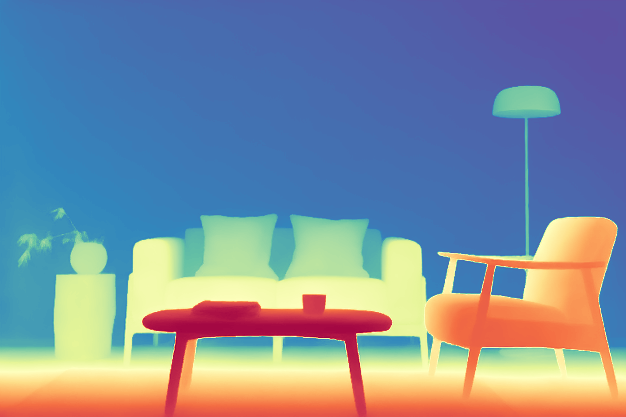

In [4]:
# Read input image
rgb_path = "/content/room.jpg"
input_image = Image.open(rgb_path)

# Predict depth
pipeline_output = pipe(
            input_image,
            denoising_steps=10,     # optional
            ensemble_size=10,       # optional
            processing_res=768,     # optional
            match_input_res=True,   # optional
            batch_size=0,           # optional
            color_map="Spectral",   # optional
            show_progress_bar=True, # optional
)

depth_pred: np.ndarray = pipeline_output.depth_np
depth_colored: Image.Image = pipeline_output.depth_colored

# Save as npy
rgb_name_base = os.path.splitext(os.path.basename(rgb_path))[0]
pred_name_base = rgb_name_base + "_pred"
np.save(f"/content/{pred_name_base}.npy", depth_pred)

# Save as 16-bit uint png
depth_to_save = (depth_pred * 65535.0).astype(np.uint16)
Image.fromarray(depth_to_save).save(f"/content/{pred_name_base}.png", mode="I;16")
# depth_image = Image.fromarray((depth_pred * 255.0).clip(0, 255).astype(np.uint8))
# depth_image.save(f"/content/{pred_name_base}.png")

# Colorize
colored_save_path = f"/content/{pred_name_base}_colored.png"
depth_colored.save(colored_save_path)

display(depth_colored)

Please restart with controlnet depth with sdxl

In [ ]:
# controlnet depth pipeline
from diffusers import ControlNetModel, AutoencoderKL, StableDiffusionXLControlNetPipeline
import torch
from PIL import Image
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
# pipe.enable_model_cpu_offload()

In [ ]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

In [ ]:
prompt = "living room"
# marigold depthで今のやつに入れるとぶっ壊れる..

# marigold
depth_image = Image.open("/content/room_pred.png")  # marigold depth

# midas
# image = Image.open("/content/room.jpg")
# bsize = image.size
# depth_image = get_depth_map(image)


controlnet_conditioning_scale = 0.9  # recommended for good generalization
seed = torch.manual_seed(0)

result_image = pipe(
    prompt,
    image=depth_image,
    num_inference_steps=30,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    seed=seed,
).images[0]

result_image = result_image.resize(bsize)
result_image.save("/content/output.png")
display(result_image)

Depth to 3d?

In [ ]:
!pip install -q trimesh pygltflib

In [10]:
import math
import os

import numpy as np
import pygltflib
import trimesh
from PIL import Image, ImageFilter

def quaternion_multiply(q1, q2):
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2
    return [
        w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2,
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
    ]


def glb_add_lights(path_input, path_output):
    """
    Adds directional lights in the horizontal plane to the glb file.
    :param path_input: path to input glb
    :param path_output: path to output glb
    :return: None
    """
    glb = pygltflib.GLTF2().load(path_input)

    N = 3  # default max num lights in Babylon.js is 4
    angle_step = 2 * math.pi / N
    elevation_angle = math.radians(75)

    light_colors = [
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]

    lights_extension = {
        "lights": [
            {"type": "directional", "color": light_colors[i], "intensity": 2.0}
            for i in range(N)
        ]
    }

    if "KHR_lights_punctual" not in glb.extensionsUsed:
        glb.extensionsUsed.append("KHR_lights_punctual")
    glb.extensions["KHR_lights_punctual"] = lights_extension

    light_nodes = []
    for i in range(N):
        angle = i * angle_step

        pos_rot = [0.0, 0.0, math.sin(angle / 2), math.cos(angle / 2)]
        elev_rot = [math.sin(elevation_angle / 2), 0.0, 0.0, math.cos(elevation_angle / 2)]
        rotation = quaternion_multiply(pos_rot, elev_rot)

        node = {
            "rotation": rotation,
            "extensions": {"KHR_lights_punctual": {"light": i}},
        }
        light_nodes.append(node)

    light_node_indices = list(range(len(glb.nodes), len(glb.nodes) + N))
    glb.nodes.extend(light_nodes)

    root_node_index = glb.scenes[glb.scene].nodes[0]
    root_node = glb.nodes[root_node_index]
    if hasattr(root_node, "children"):
        root_node.children.extend(light_node_indices)
    else:
        root_node.children = light_node_indices

    glb.save(path_output)


def extrude_depth_3d(
    path_rgb,
    path_depth,
    output_model_scale=100,
    filter_size=3,
    coef_near=0.0,
    coef_far=1.0,
    emboss=0.3,
    f_thic=0.05,
    f_near=-0.15,
    f_back=0.01,
    vertex_colors=True,
    scene_lights=True,
):
    f_far_inner = -emboss
    f_far_outer = f_far_inner - f_back

    f_near = max(f_near, f_far_inner)

    depth_image = Image.open(path_depth)
    assert depth_image.mode == "I", depth_image.mode
    depth_image = depth_image.filter(ImageFilter.MedianFilter(size=filter_size))

    w, h = depth_image.size
    d_max = max(w, h)
    depth_image = np.array(depth_image).astype(np.double)
    z_min, z_max = np.min(depth_image), np.max(depth_image)
    depth_image = (depth_image.astype(np.double) - z_min) / (z_max - z_min)
    depth_image[depth_image < coef_near] = coef_near
    depth_image[depth_image > coef_far] = coef_far
    depth_image = emboss * (depth_image - coef_near) / (coef_far - coef_near)
    rgb_image = np.array(
        Image.open(path_rgb).convert("RGB").resize((w, h), Image.Resampling.LANCZOS)
    )

    w_norm = w / float(d_max - 1)
    h_norm = h / float(d_max - 1)
    w_half = w_norm / 2
    h_half = h_norm / 2

    x, y = np.meshgrid(np.arange(w), np.arange(h))
    x = x / float(d_max - 1) - w_half  # [-w_half, w_half]
    y = -y / float(d_max - 1) + h_half  # [-h_half, h_half]
    z = -depth_image  # -depth_emboss (far) - 0 (near)
    vertices_2d = np.stack((x, y, z), axis=-1)
    vertices = vertices_2d.reshape(-1, 3)
    colors = rgb_image[:, :, :3].reshape(-1, 3) / 255.0

    faces = []
    for y in range(h - 1):
        for x in range(w - 1):
            idx = y * w + x
            faces.append([idx, idx + w, idx + 1])
            faces.append([idx + 1, idx + w, idx + 1 + w])

    # OUTER frame

    nv = len(vertices)
    vertices = np.append(
        vertices,
        [
            [-w_half - f_thic, -h_half - f_thic, f_near],  # 00
            [-w_half - f_thic, -h_half - f_thic, f_far_outer],  # 01
            [w_half + f_thic, -h_half - f_thic, f_near],  # 02
            [w_half + f_thic, -h_half - f_thic, f_far_outer],  # 03
            [w_half + f_thic, h_half + f_thic, f_near],  # 04
            [w_half + f_thic, h_half + f_thic, f_far_outer],  # 05
            [-w_half - f_thic, h_half + f_thic, f_near],  # 06
            [-w_half - f_thic, h_half + f_thic, f_far_outer],  # 07
        ],
        axis=0,
    )
    faces.extend(
        [
            [nv + 0, nv + 1, nv + 2],
            [nv + 2, nv + 1, nv + 3],
            [nv + 2, nv + 3, nv + 4],
            [nv + 4, nv + 3, nv + 5],
            [nv + 4, nv + 5, nv + 6],
            [nv + 6, nv + 5, nv + 7],
            [nv + 6, nv + 7, nv + 0],
            [nv + 0, nv + 7, nv + 1],
        ]
    )
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * 8, axis=0)

    # INNER frame

    nv = len(vertices)
    vertices_left_data = vertices_2d[:, 0]  # H x 3
    vertices_left_frame = vertices_2d[:, 0].copy()  # H x 3
    vertices_left_frame[:, 2] = f_near
    vertices = np.append(vertices, vertices_left_data, axis=0)
    vertices = np.append(vertices, vertices_left_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 * h), axis=0)
    for i in range(h - 1):
        nvi_d = nv + i
        nvi_f = nvi_d + h
        faces.append([nvi_d, nvi_f, nvi_d + 1])
        faces.append([nvi_d + 1, nvi_f, nvi_f + 1])

    nv = len(vertices)
    vertices_right_data = vertices_2d[:, -1]  # H x 3
    vertices_right_frame = vertices_2d[:, -1].copy()  # H x 3
    vertices_right_frame[:, 2] = f_near
    vertices = np.append(vertices, vertices_right_data, axis=0)
    vertices = np.append(vertices, vertices_right_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 * h), axis=0)
    for i in range(h - 1):
        nvi_d = nv + i
        nvi_f = nvi_d + h
        faces.append([nvi_d, nvi_d + 1, nvi_f])
        faces.append([nvi_d + 1, nvi_f + 1, nvi_f])

    nv = len(vertices)
    vertices_top_data = vertices_2d[0, :]  # H x 3
    vertices_top_frame = vertices_2d[0, :].copy()  # H x 3
    vertices_top_frame[:, 2] = f_near
    vertices = np.append(vertices, vertices_top_data, axis=0)
    vertices = np.append(vertices, vertices_top_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 * w), axis=0)
    for i in range(w - 1):
        nvi_d = nv + i
        nvi_f = nvi_d + w
        faces.append([nvi_d, nvi_d + 1, nvi_f])
        faces.append([nvi_d + 1, nvi_f + 1, nvi_f])

    nv = len(vertices)
    vertices_bottom_data = vertices_2d[-1, :]  # H x 3
    vertices_bottom_frame = vertices_2d[-1, :].copy()  # H x 3
    vertices_bottom_frame[:, 2] = f_near
    vertices = np.append(vertices, vertices_bottom_data, axis=0)
    vertices = np.append(vertices, vertices_bottom_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 * w), axis=0)
    for i in range(w - 1):
        nvi_d = nv + i
        nvi_f = nvi_d + w
        faces.append([nvi_d, nvi_f, nvi_d + 1])
        faces.append([nvi_d + 1, nvi_f, nvi_f + 1])

    # FRONT frame

    nv = len(vertices)
    vertices = np.append(
        vertices,
        [
            [-w_half - f_thic, -h_half - f_thic, f_near],
            [-w_half - f_thic, h_half + f_thic, f_near],
        ],
        axis=0,
    )
    vertices = np.append(vertices, vertices_left_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 + h), axis=0)
    for i in range(h - 1):
        faces.append([nv, nv + 2 + i + 1, nv + 2 + i])
    faces.append([nv, nv + 2, nv + 1])

    nv = len(vertices)
    vertices = np.append(
        vertices,
        [
            [w_half + f_thic, h_half + f_thic, f_near],
            [w_half + f_thic, -h_half - f_thic, f_near],
        ],
        axis=0,
    )
    vertices = np.append(vertices, vertices_right_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 + h), axis=0)
    for i in range(h - 1):
        faces.append([nv, nv + 2 + i, nv + 2 + i + 1])
    faces.append([nv, nv + h + 1, nv + 1])

    nv = len(vertices)
    vertices = np.append(
        vertices,
        [
            [w_half + f_thic, h_half + f_thic, f_near],
            [-w_half - f_thic, h_half + f_thic, f_near],
        ],
        axis=0,
    )
    vertices = np.append(vertices, vertices_top_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 + w), axis=0)
    for i in range(w - 1):
        faces.append([nv, nv + 2 + i, nv + 2 + i + 1])
    faces.append([nv, nv + 1, nv + 2])

    nv = len(vertices)
    vertices = np.append(
        vertices,
        [
            [-w_half - f_thic, -h_half - f_thic, f_near],
            [w_half + f_thic, -h_half - f_thic, f_near],
        ],
        axis=0,
    )
    vertices = np.append(vertices, vertices_bottom_frame, axis=0)
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * (2 + w), axis=0)
    for i in range(w - 1):
        faces.append([nv, nv + 2 + i + 1, nv + 2 + i])
    faces.append([nv, nv + 1, nv + w + 1])

    # BACK frame

    nv = len(vertices)
    vertices = np.append(
        vertices,
        [
            [-w_half - f_thic, -h_half - f_thic, f_far_outer],  # 00
            [w_half + f_thic, -h_half - f_thic, f_far_outer],  # 01
            [w_half + f_thic, h_half + f_thic, f_far_outer],  # 02
            [-w_half - f_thic, h_half + f_thic, f_far_outer],  # 03
        ],
        axis=0,
    )
    faces.extend(
        [
            [nv + 0, nv + 2, nv + 1],
            [nv + 2, nv + 0, nv + 3],
        ]
    )
    colors = np.append(colors, [[0.5, 0.5, 0.5]] * 4, axis=0)

    trimesh_kwargs = {}
    if vertex_colors:
        trimesh_kwargs["vertex_colors"] = colors
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, **trimesh_kwargs)

    mesh.merge_vertices()

    current_max_dimension = max(mesh.extents)
    scaling_factor = output_model_scale / current_max_dimension
    mesh.apply_scale(scaling_factor)

    path_out_base = os.path.splitext(path_depth)[0].replace("_16bit", "")
    path_out_glb = path_out_base + ".glb"
    path_out_stl = path_out_base + ".stl"

    mesh.export(path_out_glb, file_type="glb")
    if scene_lights:
        glb_add_lights(path_out_glb, path_out_glb)

    mesh.export(path_out_stl, file_type="stl")

    return path_out_glb, path_out_stl

In [12]:
size_longest_px=512
size_longest_cm=10
filter_size=3
plane_near=0.0
plane_far=2.0
embossing=20
frame_thickness=5
frame_near=1
frame_far=1

input_image_path = "/content/room.jpg"
depth_image_path = "/content/room_pred.png"

def _process_3d(size_longest_px, filter_size, vertex_colors, scene_lights, output_model_scale=None):
        image_rgb = input_image_path
        image_depth = depth_image_path

        image_rgb_basename, image_rgb_ext = os.path.splitext(image_rgb)
        image_depth_basename, image_depth_ext = os.path.splitext(image_depth)

        image_rgb_content = Image.open(image_rgb)
        image_rgb_w, image_rgb_h = image_rgb_content.width, image_rgb_content.height
        image_rgb_d = max(image_rgb_w, image_rgb_h)
        image_new_w = size_longest_px * image_rgb_w // image_rgb_d
        image_new_h = size_longest_px * image_rgb_h // image_rgb_d

        image_rgb_new = image_rgb_basename + f"_{size_longest_px}" + image_rgb_ext
        image_depth_new = image_depth_basename + f"_{size_longest_px}" + image_depth_ext
        image_rgb_content.resize((image_new_w, image_new_h), Image.LANCZOS).save(
            image_rgb_new
        )
        Image.open(image_depth).resize((image_new_w, image_new_h), Image.LANCZOS).save(
            image_depth_new
        )

        path_glb, path_stl = extrude_depth_3d(
            image_rgb_new,
            image_depth_new,
            output_model_scale=size_longest_cm * 10 if output_model_scale is None else output_model_scale,
            filter_size=filter_size,
            coef_near=plane_near,
            coef_far=plane_far,
            emboss=embossing / 100,
            f_thic=frame_thickness / 100,
            f_near=frame_near / 100,
            f_back=frame_far / 100,
            vertex_colors=vertex_colors,
            scene_lights=scene_lights,
        )

        return path_glb, path_stl

path_files_glb, path_files_stl = _process_3d(size_longest_px, filter_size, vertex_colors=True, scene_lights=False)
print(path_files_glb, path_files_stl)
# 面白い壁画ができる

/content/room_pred_512.glb /content/room_pred_512.stl
